# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

import torch
import torch.nn.functional as F
from torch import nn, Tensor

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import forward_euler_integration_analytic

# Distribution Generation

We generate and visualize our input and output distributions that we want to flow from.

For the analytical solution derived above, the input distribution must always be an n-dimensional independent Gaussian, but our output can be arbitrary.

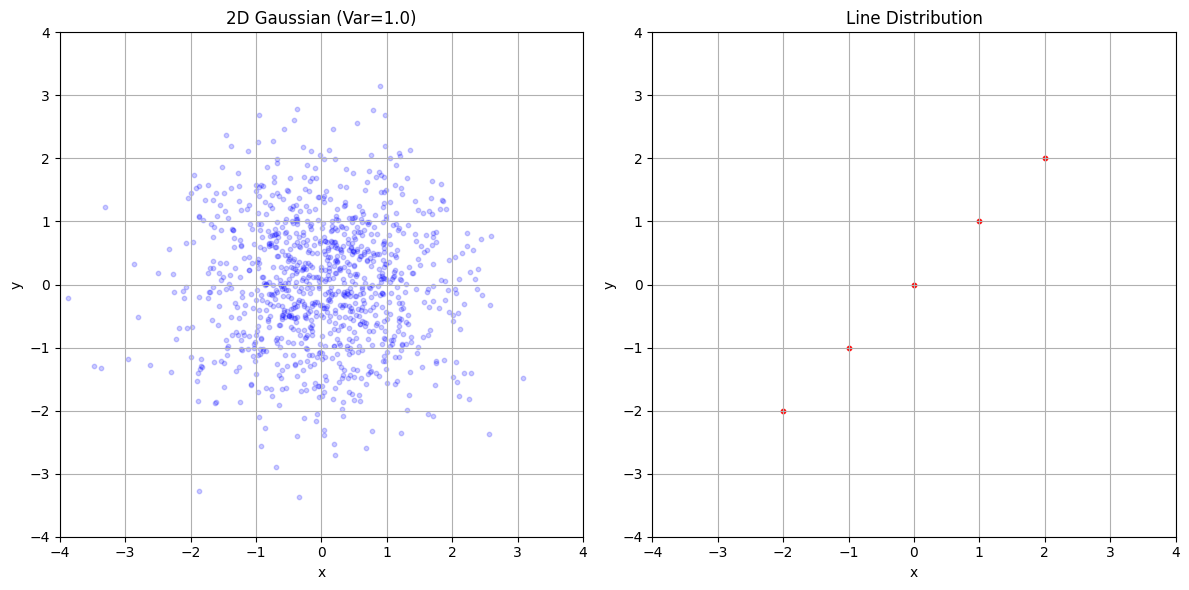

torch.Size([5, 2])


In [2]:
def generate_gaussian(n_dims, num_points, noise_std=1.0):
    """
    Generate an n-dimensional independent Gaussian distribution with specified variance.
    """
    return torch.randn(num_points, n_dims) * (noise_std)

def generate_diagonal_points(num_points=10, upper = 2, lower = -2):
    # Create equally spaced points along the diagonal
    t = torch.linspace(lower, upper, num_points)
    x = t
    y = t
    return torch.stack([x, y], dim=1)
    
# Generate samples with different variances
sigma_i = 1.0
sigma_f = 0.05
num_points = 1000
gaussian_samples1 = generate_gaussian(n_dims=2, num_points=num_points, noise_std=sigma_i)  # Default variance
diagonal_samples = generate_diagonal_points(num_points=5, upper = 2, lower = -2)

# Initial and final distributions
initial_dist = gaussian_samples1
final_dist = diagonal_samples

x_lim_params = (-4, 4)
y_lim_params = (-4, 4)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot Gaussian distribution with variance=1.0
plt.subplot(1, 2, 1)
plt.scatter(initial_dist[:, 0].numpy(), initial_dist[:, 1].numpy(), 
            c='blue', alpha=0.2, s=10)
plt.title('2D Gaussian (Var=1.0)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

# Plot Spiral distribution
plt.subplot(1, 2, 2)
plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(), 
            c='red', alpha=0.9, s=10)
plt.title('Line Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

plt.tight_layout()
plt.show()

print (final_dist.shape)

# Using The Analytical Flow

In [3]:
# Define the scheduling functions and their derivatives
def alpha(t):
    return 1 - t**2

def alpha_prime(t):
    return -2 * t

def beta(t):
    return t**2

def beta_prime(t):
    return 2 * t

# Run integration
start_time = time.time()

# Run the integration
trajectory = forward_euler_integration_analytic(
    initial_points=initial_dist,
    data=final_dist,
    t_start=0.0,
    t_end=1.0,
    num_steps=100,
    sigma_i=sigma_i,
    sigma_f=sigma_f,
    alpha=alpha,          # Pass the alpha function
    alpha_prime=alpha_prime,  # Pass its derivative
    beta=beta,            # Pass the beta function
    beta_prime=beta_prime,    # Pass its derivative
    coefficients=None     # Uniform weights if None
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")


Integration completed in 0.1331 seconds


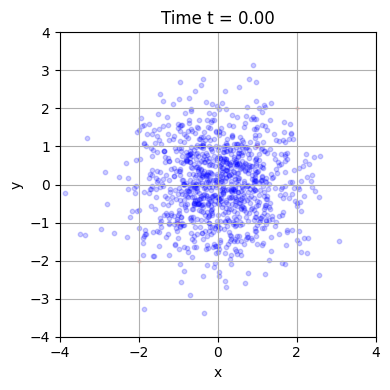

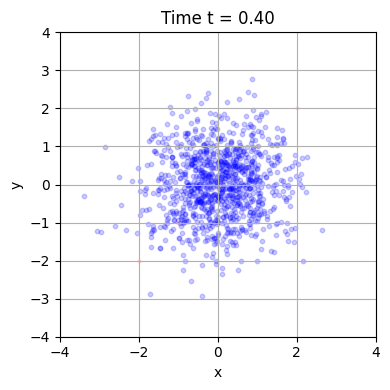

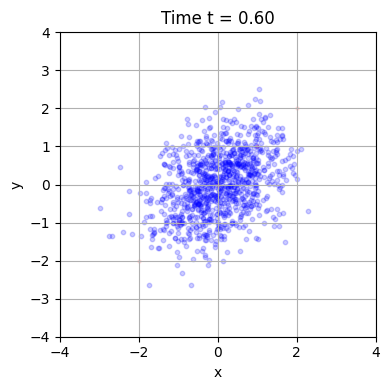

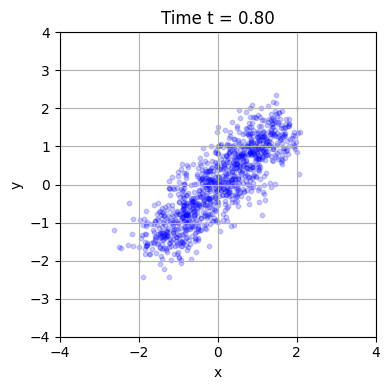

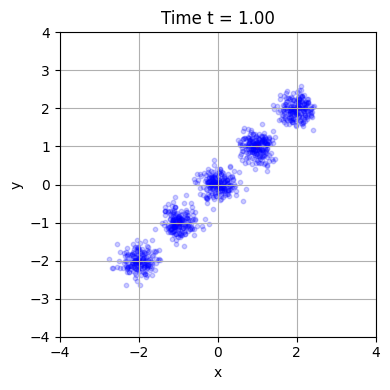

In [4]:
steps_to_plot = [0, 20, 40, 60, 80, 100]
for i, step in enumerate(steps_to_plot):
    current_time = step/max(steps_to_plot)
    current_points = trajectory[step]
    
    plt.figure(figsize=(4, 4))
    plt.scatter(current_points[:, 0].numpy(), current_points[:, 1].numpy(),
               c='blue', alpha=0.2, s=10, label='Current Points')
    plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(),
               c='red', alpha=0.1, s=5, label='Target Distribution')
    
    plt.title(f'Time t = {current_time:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(x_lim_params)  
    plt.ylim(y_lim_params)  
    plt.grid(True)    
    plt.tight_layout()
    plt.show()

## Animated GIF

In [6]:
def animate_trajectory(trajectory, final_dist):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Initialize scatter plots
    current_scatter = ax.scatter([], [], c='blue', alpha=0.2, s=10, label='Current Points')
    target_scatter = ax.scatter(final_dist[:, 0], final_dist[:, 1], c='red', alpha=1.0, s=15, label='Target Distribution')
    
    ax.set_xlim(x_lim_params)
    ax.set_ylim(y_lim_params)
    ax.grid(True)
    ax.legend(loc='upper right')
    
    def update(frame):
        current_scatter.set_offsets(trajectory[frame])
        ax.set_title(f'Time t = {frame/(len(trajectory)-1):.2f}')
        return current_scatter,
    
    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=50, blit=True)
    plt.close()
    return ani

os.makedirs('imgs', exist_ok=True)

# Create animation and save
start_time = time.time()
ani = animate_trajectory(trajectory.numpy(), final_dist.numpy())
ani.save('imgs/flow_matching_analytic_line.gif', writer='pillow', fps=20, dpi=80)
# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Gif made in {elapsed_time:.4f} seconds")

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

Gif made in 15.1374 seconds
